In [ ]:
!pip install kaggle-environments
!pip install termcolor pygame chex

In [61]:
# Подключаем нужные библиотеки
from kaggle_environments import make, evaluate
import numpy as np
import random
import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math
from matplotlib.colors import LinearSegmentedColormap
warnings.filterwarnings('ignore')

# Обозначения для ходов:
# 0 - камень
# 1 - бумага
# 2 - ножницы

# Создаем окружение для игры с заданным количеством шагов (ходов)
env = make("rps", configuration={"episodeSteps": 200})

In [60]:
%%writefile rock_agent.py

# 1. Агент, который всегда выбирает "камень"
def rock_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'камень' (0).
    """
    return 0

Overwriting rock_agent.py


In [59]:
%%writefile paper_agent.py
# 2. Агент, который всегда выбирает "бумагу"
def paper_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'бумагу' (1).
    """
    return 1

Overwriting paper_agent.py


In [58]:
%%writefile scissors_agent.py
# 3. Агент, который всегда выбирает "ножницы"
def scissors_agent(observation, configuration):
    """
    Агент, который всегда выбирает 'ножницы' (2).
    """
    return 2

Overwriting scissors_agent.py


In [57]:
%%writefile random_choice_agent.py
# 4. Агент случайного выбора
import random
def random_choice_agent(observation, configuration):
    """
    Случайный выбор действия.
    """
    return random.randint(0, 2)

Overwriting random_choice_agent.py


In [56]:
%%writefile rock_paper_agent.py
# 5. Агент, который случайно выбирает между "камнем" и "бумагой"
import random
def rock_paper_agent(observation, configuration):
    """
    Случайно выбирает между 'камнем' (0) и 'бумагой' (1).
    """
    return random.randint(0, 1)

Overwriting rock_paper_agent.py


In [55]:
%%writefile paper_scissors_agent.py
# 6. Агент, который случайно выбирает между "бумагой" и "ножницами"
import random
def paper_scissors_agent(observation, configuration):
    """
    Случайно выбирает между 'бумагой' (1) и 'ножницами' (2).
    """
    return random.randint(1, 2)

Overwriting paper_scissors_agent.py


In [54]:
%%writefile copy_opponent_agent.py
# 7. Агент, который копирует последний ход оппонента
import random
def copy_opponent_agent(observation, configuration):
    """
    Копирует последний ход противника. Если ход первый, выбирает случайно.
    """
    if observation.step > 0:
        return observation.lastOpponentAction  # копирует предыдущий ход противника
    else:
        return random.randrange(0, configuration.signs)  # случайный ход на первом шаге

Overwriting copy_opponent_agent.py


In [39]:
%%writefile cycle_agent.py
# 8. Циклический агент
def cycle_agent(observation, configuration):
    """
    Агент, который циклически выбирает 'камень' (0), 'бумагу' (1), 'ножницы' (2).
    """
    if observation.step == 0:
        return 0  # Начинаем с 'камня'
    else:
        # Циклически увеличиваем действие на 1 по модулю 3
        return (observation.step) % 3

Overwriting cycle_agent.py


In [50]:
%%writefile biased_scissors_agent.py
# 9. Агент, который чаще выбирает "ножницы" (с вероятностью 70%)

import random
def biased_scissors_agent(observation, configuration):
    """
    Агент, который выбирает 'ножницы' с вероятностью 70%, иначе выбирает случайно между 'камнем' и 'бумагой'.
    """

    if random.random() < 0.7:
        return 2  # 'ножницы'
    else:
        return random.choice([0, 1])  # 'камень' или 'бумага'

Overwriting biased_scissors_agent.py


In [42]:
%%writefile losing_agent.py
# 10. Агент, который всегда проигрывает
def losing_agent(observation, configuration):
    """
    Агент, который всегда выбирает ход, проигрывающий последнему ходу противника.
    Если это первый ход, выбирает 'камень' (0).
    """
    if observation.step == 0:
        return 0
    else:
        # Выбираем ход, который проигрывает последнему ходу противника
        return (observation.lastOpponentAction + 2) % 3

Overwriting losing_agent.py


In [51]:
%%writefile Jonson_agent.py
# 11. Агент Джонсона с анализом паттернов противника
import numpy as np
import collections
def Jonson_agent(observation, configuration):
    """
    Агент с анализом паттернов противника. Использует таблицу частот для предсказания.
    """
    k = 2
    global table, action_seq
    if observation.step % 25 == 0:
        action_seq, table = [], collections.defaultdict(lambda: [1, 1, 1])  # обновляет таблицу каждые 25 шагов
    if len(action_seq) <= 2 * k + 1:
        action = int(np.random.randint(3))
        if observation.step > 0:
            action_seq.extend([observation.lastOpponentAction, action])  # добавляет последний ход противника
        else:
            action_seq.append(action)
        return action

    key = ''.join([str(a) for a in action_seq[:-1]])  # ключ на основе последовательности ходов
    table[key][observation.lastOpponentAction] += 1  # обновляет таблицу по ключу

    action_seq[:-2] = action_seq[2:]
    action_seq[-2] = observation.lastOpponentAction
    key = ''.join([str(a) for a in action_seq[:-1]])

    if observation.step < 50:
        next_opponent_action_pred = np.argmax(table[key])  # предсказание по таблице
    else:
        scores = np.array(table[key])
        next_opponent_action_pred = np.random.choice(3, p=scores/scores.sum())

    action = (next_opponent_action_pred + 1) % 3
    if observation.step > 90:
        action = next_opponent_action_pred
    action_seq[-1] = action
    return int(action)

Overwriting Jonson_agent.py


In [52]:
%%writefile statistical_agent.py
# 12. Агент, который анализирует статистику ходов противника
import random
action_histogram = {}
def statistical_agent(observation, configuration):
    """
    Запоминает ходы противника и выбирает действие, чтобы противодействовать
    наиболее частому ходу противника.
    """
    global action_histogram
    if observation.step == 0:
        action_histogram = {}  # очищает историю в начале
        return random.randint(0, 2)  # случайный ход в начале

    action = observation.lastOpponentAction
    action_histogram[action] = action_histogram.get(action, 0) + 1  # считает ходы противника

    mode_action = max(action_histogram, key=action_histogram.get)  # находит наиболее частый ход
    return (mode_action + 1) % configuration.signs  # возвращает контр-ход

Overwriting statistical_agent.py


In [53]:
%%writefile even_odd_agent.py
# 13. Агент, который выбирает действие на основе остатка от деления шага на 2
def even_odd_agent(observation, configuration):
    """
    Агент, который выбирает 'камень' на четных шагах и 'бумагу' на нечетных.
    """
    if observation.step % 2 == 0:
        return 0  # 'камень'
    else:
        return 1  # 'бумага'

Overwriting even_odd_agent.py


In [62]:
# Турнир между агентами
agents = ['rock_agent', 'paper_agent', 'scissors_agent',
          'copy_opponent_agent', 'random_choice_agent',
          'statistical_agent', 'Jonson_agent', 'cycle_agent',
          'rock_paper_agent', 'paper_scissors_agent',
          'even_odd_agent', 'biased_scissors_agent',
          'losing_agent']

# Добавляем .py к каждому агенту
agents_py = [i + ".py" for i in agents]
n_agents = len(agents)

# Инициализируем матрицу результатов
scores = np.zeros((n_agents, n_agents))

# Играем каждый агент против каждого
for i in range(n_agents):
    for j in range(i + 1, n_agents):
        result = evaluate("rps", [agents_py[i], agents_py[j]], configuration={"episodeSteps": 200}, num_episodes=1)
        scores[i][j] = result[0][0]  # сохраняем результат для агента i
        scores[j][i] = result[0][1]  # сохраняем результат для агента j

# Определяем победителя
vic = []
for i in range(n_agents):
    cnt_vic = sum(1 for j in range(n_agents) if scores[i][j] > 0)  # считаем победы агента
    vic.append(cnt_vic)

# Определяем индексы победителей
i_victors = [i for i, v in enumerate(vic) if v == max(vic)]
if len(i_victors) > 1:
    print("The winners are", '\n', *[agents_py[i] for i in i_victors], "!")
else:
    print("The winner is", agents_py[i_victors[0]], "!")

The winner is statistical_agent.py !


In [63]:
df_scores = pd.DataFrame(scores, index=agents, columns=agents) # строим сводную таблицу итогов турнира
df_scores

rock_agent  paper_agent  scissors_agent  \
rock_agent                    0.0       -199.0           199.0   
paper_agent                 199.0          0.0          -199.0   
scissors_agent             -199.0        199.0             0.0   
copy_opponent_agent           0.0          0.0             0.0   
random_choice_agent           0.0          0.0             0.0   
statistical_agent           197.0        198.0           197.0   
Jonson_agent                 72.0         26.0             0.0   
cycle_agent                   0.0          0.0             0.0   
rock_paper_agent             98.0       -103.0             0.0   
paper_scissors_agent          0.0        103.0          -107.0   
even_odd_agent               99.0       -100.0             0.0   
biased_scissors_agent      -116.0        117.0             0.0   
losing_agent               -198.0       -199.0          -197.0   

                       copy_opponent_agent  random_choice_agent  \
rock_agent                             0.0                  0.0   
paper_agent                            0.0                  0.0   
scissors_agent                         0.0                  0.0   
copy_opponent_agent                    0.0                  0.0   
random_choice_agent                    0.0                  0.0   
statistical_agent                     40.0                  0.0   
Jonson_agent                          21.0                  0.0   
cycle_agent                          199.0                  0.0   
rock_paper_agent                       0.0                 27.0   
paper_scissors_agent                   0.0                  0.0   
even_odd_agent                         0.0                  0.0   
biased_scissors_agent                  0.0                  0.0   
losing_agent                         -99.0                  0.0   

                       statistical_agent  Jonson_agent  cycle_agent  \
rock_agent                        -197.0         -72.0          0.0   
paper_agent                       -198.0         -26.0          0.0   
scissors_agent                    -197.0           0.0          0.0   
copy_opponent_agent                -40.0         -21.0       -199.0   
random_choice_agent                  0.0           0.0          0.0   
statistical_agent                    0.0           0.0          0.0   
Jonson_agent                         0.0           0.0          0.0   
cycle_agent                          0.0           0.0          0.0   
rock_paper_agent                   -34.0         -43.0          0.0   
paper_scissors_agent                 0.0           0.0          0.0   
even_odd_agent                     -98.0         -37.0          0.0   
biased_scissors_agent              -94.0           0.0          0.0   
losing_agent                      -196.0         -78.0        198.0   

                       rock_paper_agent  paper_scissors_agent  even_odd_agent  \
rock_agent                        -98.0                   0.0           -99.0   
paper_agent                       103.0                -103.0           100.0   
scissors_agent                      0.0                 107.0             0.0   
copy_opponent_agent                 0.0                   0.0             0.0   
random_choice_agent               -27.0                   0.0             0.0   
statistical_agent                  34.0                   0.0            98.0   
Jonson_agent                       43.0                   0.0            37.0   
cycle_agent                         0.0                   0.0             0.0   
rock_paper_agent                    0.0                 -46.0             0.0   
paper_scissors_agent               46.0                   0.0            43.0   
even_odd_agent                      0.0                 -43.0             0.0   
biased_scissors_agent               0.0                  60.0             0.0   
losing_agent                      -69.0                 -59.0            99.0   

                       biased

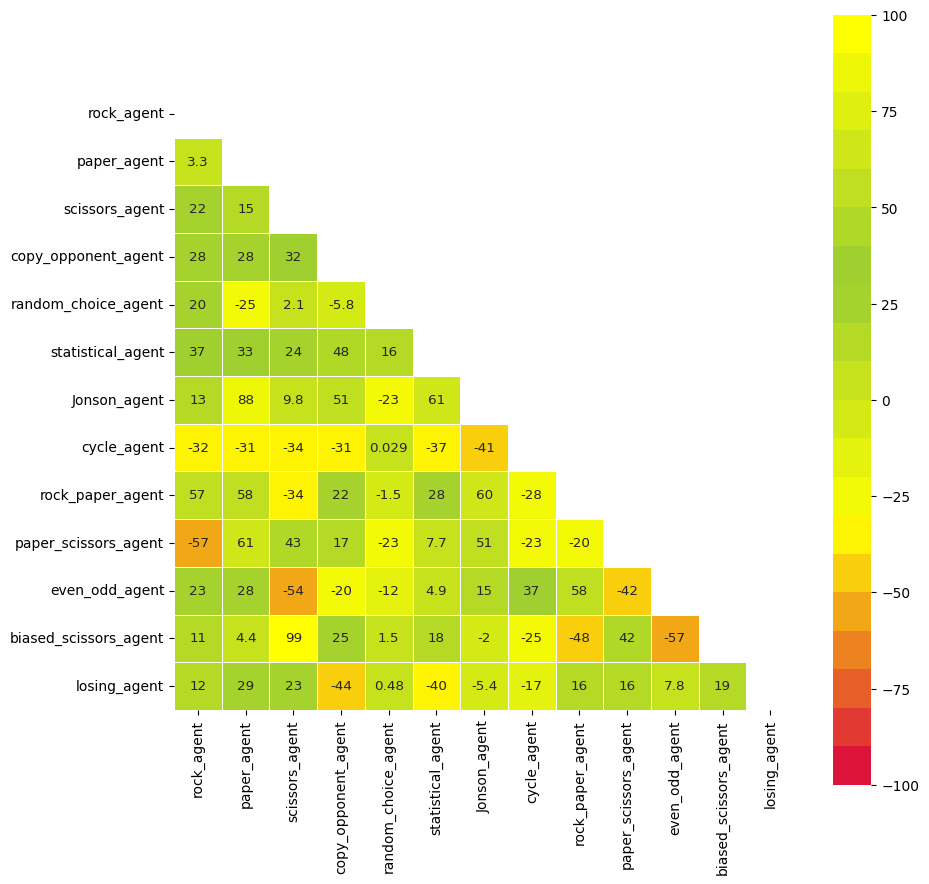

In [64]:
# Построение дополнительной визуализации

cmatrix = df_scores.corr() * 100
cmap = LinearSegmentedColormap.from_list('RedGreenRed', ['crimson', 'yellow', 'yellowgreen', 'yellow'], 20)
mask = np.triu(np.ones(cmatrix.shape[0]), k=0)

fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(ax=ax, data=cmatrix, cmap=cmap, vmin=-100, vmax=100, linewidths=.5, square=True, annot=True, mask=mask, annot_kws={'size':35 / math.sqrt(cmatrix.shape[0])})
plt.show()

In [69]:
# Создаем окружение для игры с заданным количеством шагов (ходов)
env = make("rps", configuration={"episodeSteps": 100})

# Здесь загружаем созданных агентов
# (предполагается, что файлы агентов уже созданы, как показано ранее)

# Дополнительные эксперименты: запуск определенных агентов против друг друга

def agent_vs_agent(player_1, player_2):  # функция для запуска визуализации игры между двумя агентами
  env.run([player_1 + ".py", player_2 + ".py"])
  env.render(mode="ipython", width=500, height=400)
  print("Результат " + player_1 + " против " + player_2 + ":", evaluate("rps", [player_1 + ".py", player_2 + ".py"], configuration={"episodeSteps": 1000}))

# Запускаем игру между агентом Jonson и другими агентами
for agent in agents:
  agent_vs_agent(agent, "Jonson_agent")

Результат rock_agent против Jonson_agent: [[-28.0, 28.0]]


Результат paper_agent против Jonson_agent: [[-59.0, 59.0]]


Результат scissors_agent против Jonson_agent: [[-38.0, 38.0]]


Результат copy_opponent_agent против Jonson_agent: [[-38.0, 38.0]]


Результат random_choice_agent против Jonson_agent: [[-28.0, 28.0]]


Результат statistical_agent против Jonson_agent: [[-28.0, 28.0]]


Результат Jonson_agent против Jonson_agent: [[0, 0]]


Результат cycle_agent против Jonson_agent: [[0, 0]]


Результат rock_paper_agent против Jonson_agent: [[-24.0, 24.0]]


Результат paper_scissors_agent против Jonson_agent: [[0, 0]]


Результат even_odd_agent против Jonson_agent: [[-50.0, 50.0]]


Результат biased_scissors_agent против Jonson_agent: [[35.0, -35.0]]


Результат losing_agent против Jonson_agent: [[-51.0, 51.0]]
